### Setup

In [1]:
import os
os.chdir("../../quantum_eigenfaces/package/")
import IPython

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import glob
import re
import csv 

from tqdm import tqdm
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

from quantum_eigenfaces.epsilon_tuning import epsilon_tuning 
from quantum_eigenfaces.utils.utils import DataSplit, TrainingConfig, TuningConfig



### Load MNIST Dataset

In [4]:
import joblib
memory_mnist = joblib.Memory('./tmp_mnist')
fetch_openml_cached_mnist = memory_mnist.cache(fetch_openml)

X, y = fetch_openml_cached_mnist('mnist_784', version=1, return_X_y=True)  

n_labels = len(set(y))

train_val_test = [0.70,0.15,0.15]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=train_val_test[2], random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=train_val_test[1]/(1-train_val_test[2]), random_state=1)

tot = len(X_train) + len(X_val) + len(X_test) 
print(f"Datapoints number: {tot}")
print(f"Classes number: {n_labels}")
print(f"Training set: {len(X_train)/tot}")
print(f"Validation set: {len(X_val)/tot}")
print(f"Test set: {len(X_test)/tot}")


X_train = X_train.to_numpy()
X_valid = X_val.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy().astype(int)
y_valid = y_val.to_numpy().astype(int)
y_test = y_test.to_numpy().astype(int)



Datapoints number: 70000
Classes number: 10
Training set: 0.7
Validation set: 0.15
Test set: 0.15


### Load Outliers: Fashion MNIST

In [5]:

import joblib
memory = joblib.Memory('./tmp')
fetch_openml_cached = memory.cache(fetch_openml)

X, y = fetch_openml_cached(data_id=40996, return_X_y=True) # Fashion MNIST


n_labels = len(set(y))

train_val_test = [0.70,0.05,0.05]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=train_val_test[2], random_state=1)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=train_val_test[1]/(1-train_val_test[2]), random_state=1)



tot = len(X_train2) + len(X_val2) + len(X_test2) 
print(f"Datapoints number: {tot}")
print(f"Classes number: {n_labels}")
print(f"Training set: {len(X_train2)/tot}")
print(f"Validation set: {len(X_val2)/tot}")
print(f"Test set: {len(X_test2)/tot}")


________________________________________________________________________________
[Memory] Calling sklearn.datasets._openml.fetch_openml...
fetch_openml(data_id=40996, return_X_y=True)


/Users/chattershuts/Desktop/GitHub/quantum-eigenfaces/.venv/lib/python3.9/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


____________________________________________________fetch_openml - 24.3s, 0.4min
Datapoints number: 70000
Classes number: 10
Training set: 0.8999857142857143
Validation set: 0.05001428571428571
Test set: 0.05


### Combine datasets and show split shapes

In [6]:

X_valid_wa = np.concatenate([X_valid, X_val2.to_numpy()])
y_valid_wa = np.concatenate([[int(y) for y in y_valid], [-1 for _ in range(len(X_val2))]])
X_test_wa = np.concatenate([X_test, X_test2.to_numpy()])
y_test_wa = np.concatenate([[int(y) for y in y_test], [-1 for _ in range(len(X_test2))]])



### Normalization

In [7]:
X_train_n = X_train / 255
X_valid_n = X_valid / 255
X_valid_wa_n = X_valid_wa / 255
X_test_n = X_test / 255
X_test_wa_n = X_test_wa / 255

In [8]:
print(f"X_train_n:    {X_train.shape}")
print(f"y_train:      {y_train.shape}")
print("------------------------")
print(f"X_valid_n:    {X_valid.shape}")
print(f"y_valid:      {y_valid.shape}")
print(f"X_valid_wa_n: {X_valid_wa.shape}")
print(f"y_valid_wa:   {y_valid_wa.shape}")
print("------------------------")
print(f"X_test_n:     {X_test.shape}")
print(f"y_test:       {y_test.shape}")
print(f"X_test_wa_n:  {X_test_wa.shape}")
print(f"y_test_wa:    {y_test_wa.shape}")

X_train_n:    (49000, 784)
y_train:      (49000,)
------------------------
X_valid_n:    (10500, 784)
y_valid:      (10500,)
X_valid_wa_n: (14001, 784)
y_valid_wa:   (14001,)
------------------------
X_test_n:     (10500, 784)
y_test:       (10500,)
X_test_wa_n:  (14000, 784)
y_test_wa:    (14000,)


### Formalize dataset splits and fitting configurations

In [9]:

datasplit_without_outliers = DataSplit(X_train=X_train_n, 
                                       y_train=y_train, 
                                       X_valid=X_valid_n, 
                                       y_valid=y_valid, 
                                       X_test=X_test_n, 
                                       y_test=y_test)

datasplit_with_outliers = DataSplit(X_train=X_train_n, 
                                    y_train=y_train, 
                                    X_valid=X_valid_wa_n, 
                                    y_valid=y_valid_wa, 
                                    X_test=X_test_wa_n, 
                                    y_test=y_test_wa)

training_config = TrainingConfig(n_components=60)
tuning_config = TuningConfig(tot_num_of_deltas=1600)



### Delta Tuning

In [10]:
from quantum_eigenfaces.quantum_model import QuantumModel
qm = QuantumModel(X_train=X_train_n,
                  y_train=y_train,
                  X_valid=X_valid_wa_n,
                  y_valid=y_valid_wa,
                  X_test=X_test_wa_n,
                  y_test=y_test_wa,
                  reshaper=(28, 28),
                  tot_num_of_deltas=1600
                  )
qm._training(n_components=60)


Normalization Threshold is: 0.74854


In [11]:
tuning_performance = qm._tuning(show_plot=False)


Min delta:  0.24308063316243006 ; Max delta:  62.31349514634041


tuning delta1...: 100%|█████████████████████| 1600/1600 [08:09<00:00,  3.27it/s]

Chosen delta1: 22.08410773998692


In [12]:
filename = "MNIST_tuning_performance.parquet"
tuning_performance.to_parquet(filename)

In [13]:
tuning_performance__ = pd.read_parquet(filename)

In [14]:
tuning_performance__

,Delta,Accuracy,False Acceptance Rate,False Recognition Rate,Precision,Recall,F1-Score
0,0.243081,0.250125,0.000000,0.749875,0.250071,1.000000,0.400091
1,0.281875,0.250196,0.000000,0.749804,0.250089,1.000000,0.400114
2,0.320669,0.250482,0.000000,0.749518,0.250161,1.000000,0.400206
3,0.359463,0.251125,0.000000,0.748875,0.250322,1.000000,0.400412
4,0.398257,0.251553,0.000000,0.748447,0.250429,1.000000,0.400549
...,...,...,...,...,...,...,...
1595,62.119525,0.731591,0.249982,0.000000,1.000000,0.000286,0.000571
1596,62.158319,0.731591,0.249982,0.000000,1.000000,0.000286,0.000571
1597,62.197113,0.731591,0.249982,0.000000,1.000000,0.000286,0.000571
1598,62.235907,0.731591,0.249982,0.000000,1.000000,0.000286,0.000571


In [57]:
from typing import Union
import matplotlib

def plot_metrics(metrics: pd.DataFrame, chosen_delta1: float, show: bool = True,
                 file_path: Union[str, None] = None, save: bool = True) -> None:
    fontsize = 28
    legend_fontsize = 24
    
    delta1s = metrics["Delta"]

    # Set the figure size
    matplotlib.rcParams.update({'font.size': fontsize - 5})
    plt.figure(figsize=(15, 5))

    # First graph
    plt.subplot(1, 3, 1)
    plt.plot(delta1s, metrics["Accuracy"], label='Accuracy')
    plt.axvline(x=chosen_delta1, c="red")
    plt.legend(fontsize=legend_fontsize - 8)
    plt.xlabel('$\delta$', fontsize=fontsize - 5)
    plt.ylabel('Metrics', fontsize=fontsize - 5)
    plt.grid(True)

    # Second graph
    f = plt.subplot(1, 3, 2)
    plt.plot(delta1s, metrics["F1-Score"], label='F1 Score')
    plt.plot(delta1s, metrics["Precision"], label='Precision')
    plt.plot(delta1s, metrics["Recall"], label='Recall')
    plt.axvline(x=chosen_delta1, c="red")
    plt.legend(fontsize=legend_fontsize - 8, loc = "lower right")
    plt.xlabel('$\delta$', fontsize=fontsize - 5)
    plt.ylabel('Metrics', fontsize=fontsize - 5)
    plt.grid(True)

    # Third graph
    plt.subplot(1, 3, 3)
    plt.plot(delta1s, metrics["False Acceptance Rate"], label='FAR')
    plt.plot(delta1s, metrics["False Recognition Rate"], label='FRR')
    plt.axvline(x=chosen_delta1, c="red")
    plt.legend(fontsize=legend_fontsize - 8)
    plt.xlabel('$\delta$', fontsize=fontsize - 5)
    plt.ylabel('Metrics', fontsize=fontsize - 5)
    plt.grid(True)
    plt.subplots_adjust(wspace=0.4)

    if show:
        plt.show()

    if save:
        matplotlib.rcParams.update({'font.size': fontsize})

        figsize = (6, 8)
        plt.clf()

        plt.figure(figsize=figsize)
        plt.plot(delta1s, metrics["Accuracy"], label='Accuracy')
        plt.axvline(x=chosen_delta1, c="red")
        plt.legend(fontsize=legend_fontsize)
        plt.xlabel('$\delta$', fontsize=fontsize)
        plt.ylabel('Metrics', fontsize=fontsize)
        plt.grid(True)
        filename = 'DELTA_acc.pdf'
        plt.savefig(filename, bbox_inches='tight')
        print(f"Saved plot at {filename}")

        plt.clf()
        plt.figure(figsize=figsize)
        plt.plot(delta1s, metrics["F1-Score"], label='F1 Score')
        plt.plot(delta1s, metrics["Precision"], label='Precision')
        plt.plot(delta1s, metrics["Recall"], label='Recall')
        plt.axvline(x=chosen_delta1, c="red")
        plt.legend(fontsize=legend_fontsize, loc="lower right")
        plt.xlabel('$\delta$', fontsize=fontsize)
        plt.ylabel('Metrics', fontsize=fontsize)
        plt.grid(True)
        filename = "DELTA_pre_rec_and_f1.pdf"
        plt.savefig(filename, bbox_inches='tight')
        print(f"Saved plot at {filename}")

        plt.clf()
        plt.figure(figsize=figsize)
        plt.plot(delta1s, metrics["False Acceptance Rate"], label='FAR')
        plt.plot(delta1s, metrics["False Recognition Rate"], label='FRR')
        plt.axvline(x=chosen_delta1, c="red")
        plt.legend(fontsize=legend_fontsize)
        plt.xlabel('$\delta$', fontsize=fontsize)
        plt.ylabel('Metrics', fontsize=fontsize)
        plt.grid(True)
        filename = 'DELTA_far_and_frr.pdf'
        plt.savefig(filename, bbox_inches='tight')
        print(f"Saved plot at {filename}")
        plt.clf()


    if file_path is not None:
        plt.savefig(file_path, bbox_inches='tight')


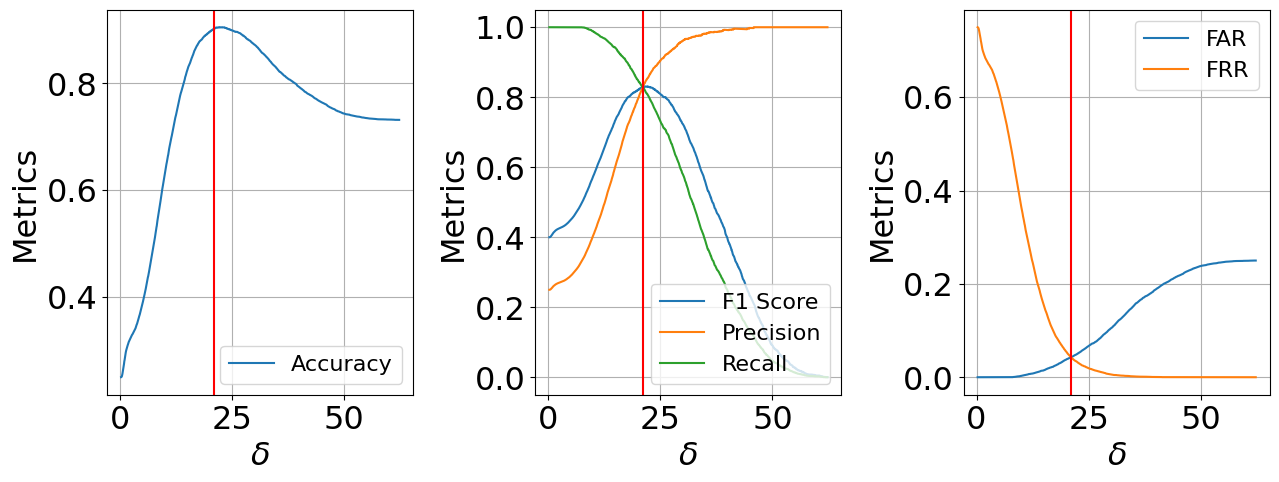

Saved plot at DELTA_acc.pdf
Saved plot at DELTA_pre_rec_and_f1.pdf
Saved plot at DELTA_far_and_frr.pdf


<Figure size 640x480 with 0 Axes>

<Figure size 600x800 with 0 Axes>

<Figure size 600x800 with 0 Axes>

<Figure size 600x800 with 0 Axes>

In [58]:
 plot_metrics(metrics=tuning_performance,
             chosen_delta1=qm.chosen_delta1 - 1)